In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.signal import chirp, butter, filtfilt,correlate
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from sklearn.neighbors import NearestNeighbors
from gtda.plotting import plot_point_cloud
import csv
import pandas as pd 
import plotly.graph_objects as go
from nolitsa import dimension, delay
from sklearn.decomposition import PCA
import gudhi as gd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import kmapper as km

# Parámetros de la señal y el ruido
sample_rate = 2048 # Hz
signal_duration = 2 # segundos
noise_duration = 0.976 # segundos
num_signals = 1500
mass_ratio_min = 1.0078
mass_ratio_max = 9.9759
R_min = 0.075
R_max = 0.65

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_datetime_CAPI' (most likely due to a circular import)

In [ ]:
# Generar señales de referencia
mass_ratios = np.random.uniform(mass_ratio_min, mass_ratio_max, num_signals)
reference_signals = []
for mass_ratio in mass_ratios:
    time = np.linspace(0, signal_duration, int(sample_rate * signal_duration), endpoint=False)
    signal = chirp(time, f0=10, f1=100, t1=signal_duration, method='linear')
    reference_signals.append(signal)

# Función para insertar señal en ruido
def insert_signal_in_noise(signal, noise_duration):
    noise = np.random.normal(0, 0.5, int(sample_rate * noise_duration)) # Generar ruido
    start_time = random.uniform(0, noise_duration) # Tiempo de inicio aleatorio dentro del ruido
    end_time = start_time + signal_duration # Tiempo de finalización de la señal en el ruido
    full_signal = np.concatenate([noise[:int(start_time * sample_rate)], signal, noise[int(end_time * sample_rate):]])
    return full_signal, start_time

# Generar conjunto de entrenamiento
training_data = []
for signal in reference_signals:
    R = np.random.uniform(R_min, R_max) # Coeficiente R aleatorio
    presence = random.random() < 0.5 # Probabilidad del 50% de presencia de la señal
    if presence:
        signal_in_noise, start_time = insert_signal_in_noise(signal, noise_duration)
        training_data.append((signal_in_noise, R, start_time))


In [ ]:
# Definir las funciones para el filtrado
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Parámetros del filtro
cutoff_frequency = 50.0  # Frecuencia de corte del filtro
order = 5  # Orden del filtro

# Filtrar y visualizar una señal de ejemplo
signal_data = training_data[0][0]
R_value = training_data[0][1]
start_time = training_data[0][2]

# Tiempo para la señal
time = np.arange(0, len(signal_data)/sample_rate, 1/sample_rate)

# Filtrar la señal
filtered_signal = lowpass_filter(signal_data, cutoff_frequency, sample_rate, order)


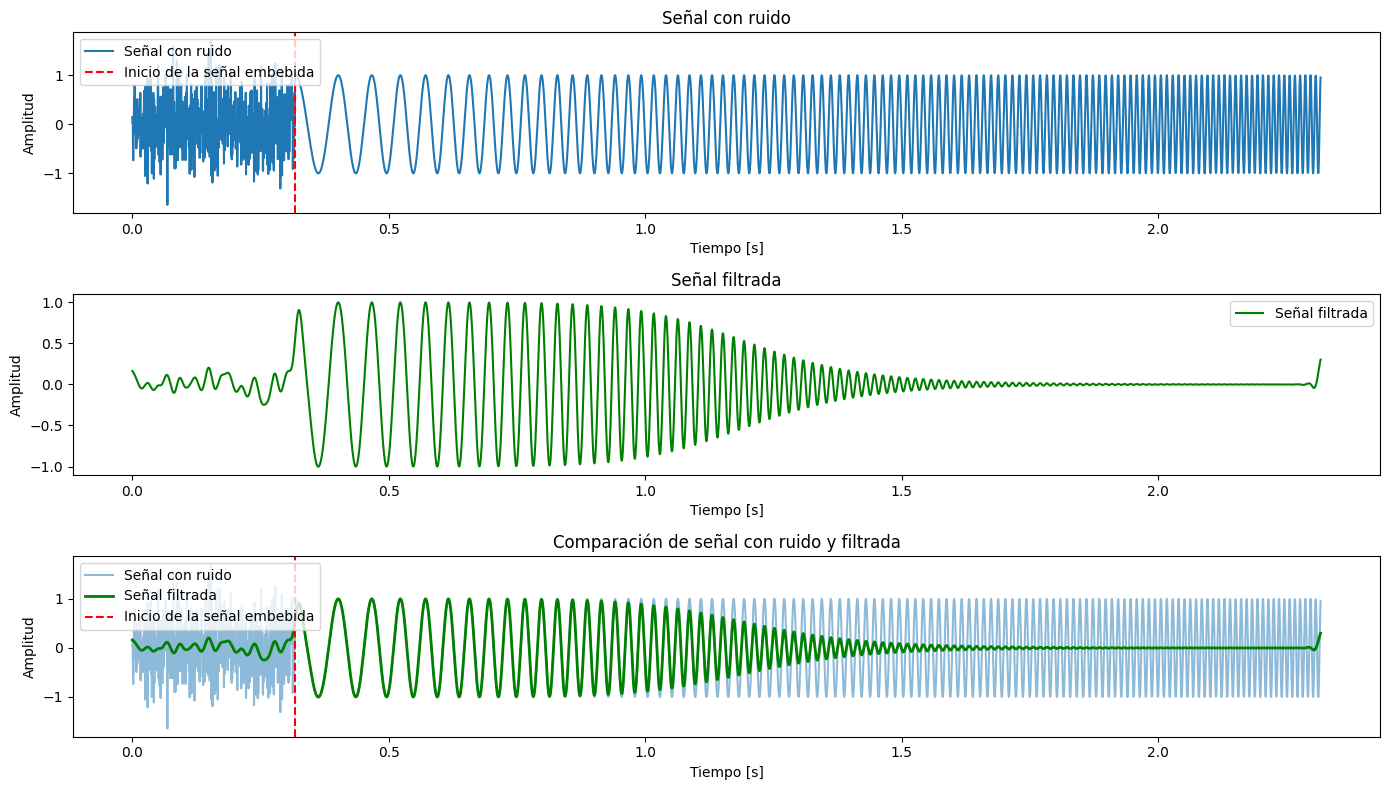

In [ ]:
# Graficar la señal original y filtrada
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(time, signal_data, label='Señal con ruido')
plt.axvline(start_time, color='red', linestyle='--', label='Inicio de la señal embebida')
plt.title('Señal con ruido')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, filtered_signal, label='Señal filtrada', color='green')
plt.title('Señal filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, signal_data, label='Señal con ruido', alpha=0.5)
plt.plot(time, filtered_signal, label='Señal filtrada', color='green', linewidth=2)
plt.axvline(start_time, color='red', linestyle='--', label='Inicio de la señal embebida')
plt.title('Comparación de señal con ruido y filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
max_embedding_time_delay = 3
max_embedding_dimension = 2


# Encajar la señal de ruido
embedder = SingleTakensEmbedding(
    parameters_type="search",
    n_jobs=-1,  # Usar todos los núcleos disponibles
    time_delay=max_embedding_time_delay,
    dimension=max_embedding_dimension,
    stride=1
)
embedded_noise = embedder.fit_transform(signal_data)

# Encajar la señal filtrada
embedded_filtered_signal = embedder.fit_transform(filtered_signal)

embedded_noise



array([[ 0.14849353, -0.67356721],
       [ 0.02339184, -0.73483424],
       [ 0.03621296, -0.24855845],
       ...,
       [-0.26554311,  0.60575243],
       [ 0.03764928,  0.81766244],
       [ 0.33739757,  0.95331622]])

In [ ]:
embedded_filtered_signal

array([[0.16362562, 0.15196175],
       [0.16012   , 0.1473374 ],
       [0.15622731, 0.14236818],
       ...,
       [0.22305718, 0.27405378],
       [0.2410628 , 0.2886932 ],
       [0.25812443, 0.30192167]])

In [ ]:
embedded_noise==embedded_filtered_signal

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

NameError: name 'embedded_noise' is not defined

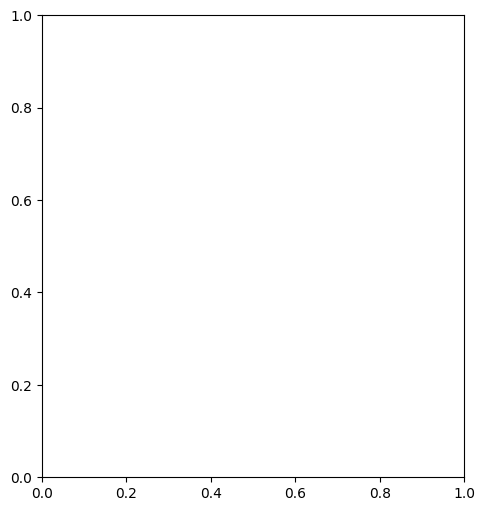

In [ ]:
# Graficar los datos embebidos del ruido y la señal filtrada por separado
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(embedded_noise[:, 0], embedded_noise[:, 1], s=5)
plt.title('Datos de la señal con ruido')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')

plt.subplot(1, 2, 2)
plt.scatter(embedded_filtered_signal[:, 0], embedded_filtered_signal[:, 1], s=5)
plt.title('Datos Embebidos de la Señal Filtrada')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')

plt.tight_layout()
plt.show()


In [ ]:
import gudhi as gd

# Función para calcular los complejos de Vietoris-Rips y los diagramas de persistencia
def compute_persistence(embedded_data):
    rips_complex = gd.RipsComplex(points=embedded_data)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()
    return persistence

# Calcular los diagramas de persistencia para el ruido filtrado y la señal filtrada
persistence_noise = compute_persistence(embedded_noise)
persistence_filtered_signal = compute_persistence(embedded_filtered_signal)

# Función para graficar los diagramas de persistencia
def plot_persistence_diagram(persistence, title):
    gd.plot_persistence_diagram(persistence)
    plt.title(title)
    plt.xlabel("Dimension 0")
    plt.ylabel("Dimension 1")
    plt.show()

# Graficar los diagramas de persistencia para el ruido filtrado y la señal filtrada
plot_persistence_diagram(persistence_noise, "Diagrama de Persistencia para el Ruido Filtrado")
plot_persistence_diagram(persistence_filtered_signal, "Diagrama de Persistencia para la Señal Filtrada")
